In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization

In [4]:
data = pd.read_csv("imbalancedtask1reddit.csv")
data = data.drop(["Unnamed: 0"], axis = 1)
data = data.dropna()

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
tokens1 = []
for text in data["chat1"]:
  tokens1.append(tokenizer.tokenize(text))

tokens2 = []
for text in data["chat2"]:
  tokens2.append(tokenizer.tokenize(text))

In [7]:
token_ids1 = []
for token in tokens1:
  token_ids1.append(tokenizer.convert_tokens_to_ids(token))

token_ids2 = []
for token in tokens2:
  token_ids2.append(tokenizer.convert_tokens_to_ids(token))

In [8]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Tokenize the text into words and sentences
feature1 = []
for corpus in data["chat1"]:
  words = word_tokenize(corpus)
  sentences = sent_tokenize(corpus)
  word_lengths = [len(w) for w in words if w not in stopwords.words('english')]
  avg_word_length = sum(word_lengths) / len(word_lengths)
  avg_sentence_length = len(words) / len(sentences)
  vocab = set(words)
  vocab_size = len(vocab)
  lexical_diversity = len(words) / vocab_size
  pos_tags = nltk.pos_tag(words)
  noun_count = len([w for w, pos in pos_tags if pos.startswith('NN')])
  verb_count = len([w for w, pos in pos_tags if pos.startswith('VB')])
  adj_count = len([w for w, pos in pos_tags if pos.startswith('JJ')])
  feature1.append([avg_word_length, avg_sentence_length, vocab_size, lexical_diversity, noun_count, verb_count, adj_count])

In [9]:
feature2 = []
for corpus in data["chat2"]:
  words = word_tokenize(corpus)
  sentences = sent_tokenize(corpus)
  word_lengths = [len(w) for w in words if w not in stopwords.words('english')]
  avg_word_length = sum(word_lengths) / len(word_lengths)
  avg_sentence_length = len(words) / len(sentences)
  vocab = set(words)
  vocab_size = len(vocab)
  lexical_diversity = len(words) / vocab_size
  pos_tags = nltk.pos_tag(words)
  noun_count = len([w for w, pos in pos_tags if pos.startswith('NN')])
  verb_count = len([w for w, pos in pos_tags if pos.startswith('VB')])
  adj_count = len([w for w, pos in pos_tags if pos.startswith('JJ')])
  feature2.append([avg_word_length, avg_sentence_length, vocab_size, lexical_diversity, noun_count, verb_count, adj_count])

In [10]:
maxlen = 100
padded_sequences1 = pad_sequences(token_ids1, maxlen=maxlen)

maxlen = 100
padded_sequences2 = pad_sequences(token_ids2, maxlen=maxlen)

In [11]:
feat1 = np.array(feature1)
feat2 = np.array(feature2)

In [12]:
padd1 = np.concatenate([padded_sequences1, feat1], axis = 1)
padd2 = np.concatenate([padded_sequences2, feat2], axis = 1)

In [13]:
labels = pd.get_dummies(data["label"]).values

In [14]:
padd = np.concatenate([padd1, padd2], axis = 1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(padd, labels, test_size=0.2, random_state=42)

In [16]:
model = Sequential()
model.add(Embedding(2 * (tokenizer.vocab_size + 8), 128, input_length=2 * (maxlen + 7)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(2, activation="softmax"))


# compile and train the model
batch_size = 32
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
12/12 [==============================] - 15s 371ms/step - loss: 0.6172 - accuracy: 0.7263 - val_loss: 0.5469 - val_accuracy: 0.7778
Epoch 2/30
12/12 [==============================] - 3s 242ms/step - loss: 0.5651 - accuracy: 0.7458 - val_loss: 0.5363 - val_accuracy: 0.7778
Epoch 3/30
12/12 [==============================] - 3s 222ms/step - loss: 0.5341 - accuracy: 0.7458 - val_loss: 0.5286 - val_accuracy: 0.7778
Epoch 4/30
12/12 [==============================] - 2s 203ms/step - loss: 0.3970 - accuracy: 0.7905 - val_loss: 0.5174 - val_accuracy: 0.7444
Epoch 5/30
12/12 [==============================] - 3s 221ms/step - loss: 0.1897 - accuracy: 0.9665 - val_loss: 0.7563 - val_accuracy: 0.7556
Epoch 6/30
12/12 [==============================] - 3s 236ms/step - loss: 0.0476 - accuracy: 0.9860 - val_loss: 0.8288 - val_accuracy: 0.7111
Epoch 7/30
12/12 [==============================] - 3s 223ms/step - loss: 0.0221 - accuracy: 0.9972 - val_loss: 1.0666 - val_accuracy: 0.7556


In [17]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

4/4 [==============================] - 1s 19ms/step


In [18]:
y_test = np.argmax(y_test, axis=1)

In [19]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        76
           1       0.62      0.41      0.49        37

    accuracy                           0.73       113
   macro avg       0.69      0.64      0.65       113
weighted avg       0.71      0.73      0.71       113

[[67  9]
 [22 15]]


In [20]:
from sklearn.metrics import f1_score

In [21]:
f1_macro = f1_score(y_test, y_pred, average="macro")

print("F1 macro score:", f1_macro)

F1 macro score: 0.6519622454048684


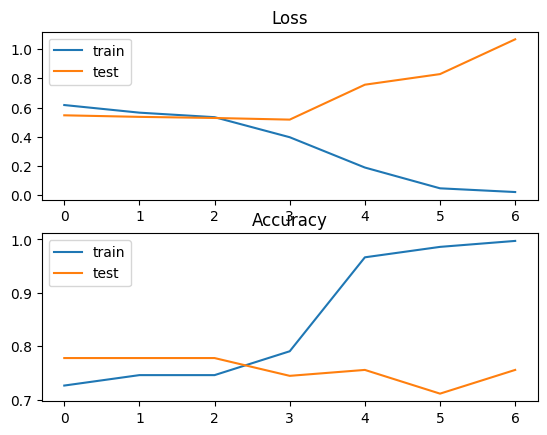

In [22]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()